In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import scipy.optimize as so

from scipy import odr
from uncertainties import unumpy, ufloat

First of all I try to find the estimator by analytically minimizing the chi2

The $\chi^2$ is defined as: $$\chi^2=\sum_{i=1}^{n} \frac{(y_i-f(x_i))^2}{\sigma_{y}^2}$$

This can be minimized by requiring $$\frac{\partial \chi^2}{\partial x}=0$$
This means  $$\frac{\partial \chi^2}{\partial x}=\sum_{i=1}^{n} -2\cdot\frac{(y_i-f(x_i))}{\sigma_{y}}\cdot \frac{\partial f(x_i)}{\partial x_i}=0$$
and  $$=\sum_{i=1}^{n} \cdot\frac{(y_i-f(x_i))}{\sigma_{y}}\cdot \frac{\partial f(x_i)}{\partial x_i}=0$$
and for constant $\sigma_y$:
$$=\sum_{i=1}^{n} (y_i-f(x_i))\cdot \frac{\partial f(x_i)}{\partial x_i}=0$$
For a linear function $f(x)=ax+b$ we get:
$$=\sum_{i=1}^{n} (y_i-ax_i-b)\cdot a=0$$
dividing by a and splitting the sum leads to:
$$=\sum_{i=1}^{n} y_i-\sum_{i=1}^{n} (ax_i+b)=0$$
$$=\sum_{i=1}^{n} (y_i-b)-a\cdot \sum_{i=1}^{n} x_i=0$$
and we arrive at:
$$\frac{\sum_{i=1}^{n} (y_i-b)}{ \sum_{i=1}^{n} x_i}=a$$

Now I define some functions

In [2]:
def Fitfunktion(params,x):   #fitfunction
    A, B = params
    return A*x+B

In [3]:
def chi2(params,x,y,sigmay):   #chi2 calculation
    chi= np.sum((y-Fitfunktion(params,x))**2/sigmay**2)
    return chi

In [4]:
def estimator(x,y,b):   #estimator calculation
    a=np.sum(y-b)/np.sum(x)
    return a

One experiment looks like that:

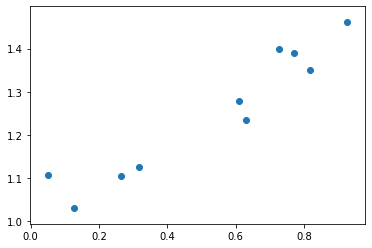

In [7]:
x=np.random.uniform(0,1,10)   #generate x-data points
        
sigmay=np.random.normal(0,0.05,10)   # generate y-deviation
b=1       #values for a and b
a=0.5
        
y_mc=a*x+b 

plt.scatter(x,y_mc+sigmay)

This data would then be fitted.

Now I define a function to repeat the experiment 1000 times

In [15]:
def Experiment_iteration(Iteration_number,a_given,b_given):
    a_fit_array=np.zeros(0)
    b_fit_array=np.zeros(0)
    a_estimator_array=np.zeros(0)
   # mode_array=np.zeros(0)
    
    
    
    for i in range(Iteration_number):
        x=np.random.uniform(0,1,10)   #generate x-data points
        
        sigmay=np.random.normal(0,0.05,10)   # generate y-deviation
        b=b_given        #values for a and b
        a=a_given
        
        y_mc=a*x+b     #calculate y-datapoints
        Optimal= so.minimize(chi2,x0=[a_given,b_given],args=(x,y_mc+sigmay,sigmay))['x']
        a_fit=Optimal[0]   #fit data to linear model
        b_fit=Optimal[1]
        
        
        a_estimator=estimator(x,y_mc+sigmay,b)   #calculate estimator
        
        a_fit_array=np.append([a_fit],[a_fit_array])
        b_fit_array=np.append([b_fit],[b_fit_array])
        
        a_estimator_array=np.append([a_estimator],[a_estimator_array])
       
    
    return a_fit_array, b_fit_array, a_estimator_array

In [16]:
Experiment1=Experiment_iteration(1000,0.5,1)

I calculate the bias as the difference between the mean value of the fit and the estimator

In [17]:
Bias=np.mean(Experiment1[0]-Experiment1[2])
Bias

0.0003500439400096764

The bias is close to zero. Therefore the estimator is unbiased

Now I add an error in x. For the fitting I now user another package which can fit for errors in both variables x and y

One experiment would now look like this:

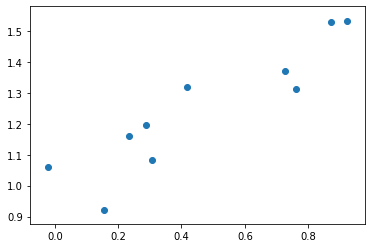

In [13]:
x=np.random.uniform(0,1,10)   #generate x-data points
        
sigmay=np.random.normal(0,0.05,10)   # generate y-deviation
sigmax=np.random.normal(0,0.05,10)  #genertae x deviation
b=1       #values for a and b
a=0.5
        
y_mc=a*x+b 

plt.scatter(x+sigmax,y_mc+sigmay)

This data would then be fitted

Now I write a function to repeat the experiment multiple times.

In [18]:
def Experiment_iteration2(Iteration_number,a_given,b_given,x_deviation,y_deviation,n):
    a_fit_array=np.zeros(0)
    b_fit_array=np.zeros(0)
    a_estimator_array=np.zeros(0)
   # mode_array=np.zeros(0)
    
    
    
    for i in range(Iteration_number):
        x=np.random.uniform(0,1,n)  #generate x-data points
        
        sigmay=np.random.normal(0,y_deviation,n)  # generate y-deviation
        sigmax=np.random.normal(0,x_deviation,n)  # generate x-deviation
        b=b_given
        a=a_given
       
        y_mc=a*x+b    #calculate y-datapoints
        
        quad_model = scipy.odr.Model(Fitfunktion)
        data = scipy.odr.RealData(x+sigmax,y_mc+sigmay,sx=sigmax,sy=sigmay)
        odr = scipy.odr.ODR(data, quad_model, beta0=[0.5, 1])
        odr.set_job(fit_type=0)
        out = odr.run()
        popt = out.beta
        perr = out.sd_beta
        
        
        a_fit=popt[0]
        b_fit=popt[1]
        
        
        a_estimator=estimator(x+sigmax,y_mc+sigmay,b)
        
        a_fit_array=np.append([a_fit],[a_fit_array])
        b_fit_array=np.append([b_fit],[b_fit_array])
        
        a_estimator_array=np.append([a_estimator],[a_estimator_array])
       
    
    return a_fit_array, b_fit_array, a_estimator_array

In [19]:
Experiment2=Experiment_iteration2(1000,0.5,1,0.05,0.05,10)

In [20]:
Bias2=np.mean(Experiment2[0]-Experiment2[2])
Bias2

0.0034299048757334863

The bias is larger but still rather close to zero

Now I increase the error in x and y to 0.2

In [23]:
Experiment3=Experiment_iteration2(1000,0.5,1,0.2,0.2,10)

In [24]:
Bias3=np.mean(Experiment3[0]-Experiment3[2])
Bias3

0.010640441022569256

The bias got even larger

Since the difference between the fit value and the estimator gets larger for larger uncertainties the estimator is biased. This is probably due to the chi2 not depending on the error of the y-values

Now I increase n

In [16]:
bias_n_array=np.zeros(0)
n_array=np.zeros(0)
for i in np.arange(10,10000,1000):
    Experiment_n=Experiment_iteration2(1000,0.5,1,0.2,0.2,i)
    bias_n=np.mean(Experiment_n[0]-Experiment_n[2])
    bias_n_array=np.append([bias_n],[bias_n_array])
    n_array=np.append([i],[n_array])

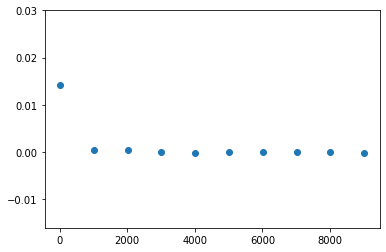

In [18]:
plt.scatter(n_array,bias_n_array)

In [19]:
bias_n_array

array([-1.04867196e-04,  3.14923635e-05, -2.45653892e-05,  1.40665302e-05,
        1.20687438e-05, -1.59782500e-04, -7.24558114e-06,  3.91995516e-04,
        3.57083146e-04,  1.41355488e-02])

In [20]:
n_array

array([9010., 8010., 7010., 6010., 5010., 4010., 3010., 2010., 1010.,
         10.])

For larger n the difference between the fit value and the estimator value reduces.

This suggests that the estimator is consistent